# Part 4: "Online" linear regression

When you are trying to fit a model to data and you get to see all of the data at once, we refer to the problem as an _offline_ or _batch_ problem, and you would try to use certain algorithms to compute the fit that can take advantage of the fact that you have a lot of available data.

But what if you only get to see one or a few data points at a time? In that case, you might want to get an initial model from whatever data you've got, and gradually improve the model as you see new data points. In this case, we refer to the problem as being an _online_ problem.

The goal of this notebook is to introduce you to online algorithms. You'll start by reviewing the offline linear regression problem, and then look at its online variant. The neat thing about the online method is that you can derive it using all the tools you already have at your disposal, namely, multivariate calculus.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Review: Offline or batch linear regression

Let's start with a quick review of the linear regression problem: given a response vector, $y$, and a data matrix $X$---whose rows are observations and columns are variables---the problem is to find the best linear model, $y \approx X \theta^*$, where $\theta^*$ is the vector of best-fit model parameters that we wish to compute. Computing it using a conventional batch linear least squares method has an asymptotic running time of $\mathcal{O}(mn^2)$.

To start, here is some code to help generate synthetic problems of a certain size, namely, $m \times (n+1)$, where $m$ is the number of observations and $n$ the number of predictors. The $+1$ comes from our usual dummy coefficient for a non-zero intercept.

In [2]:
def generate_model (n):
    """Returns a set of (random) n+1 linear model coefficients."""
    return np.random.rand (n+1, 1)

def generate_data (m, theta, sigma=1.0/(2**0.5)):
    """
    Generates 'm' noisy observations for a linear model whose
    predictor (non-intercept) coefficients are given in 'theta'.
    Decrease 'sigma' to decrease the amount of noise.
    """
    assert (type (theta) is np.ndarray) and (theta.ndim == 2) and (theta.shape[1] == 1)
    n = len (theta)
    X = np.random.rand (m, n)
    X[:, 0] = 1.0
    y = X.dot (theta) + sigma*np.random.randn (m, 1)
    return (X, y)

def estimate_coeffs (X, y):
    """
    Solves X*theta = y by a linear least squares method.
    """
    result = np.linalg.lstsq (X, y, rcond=None)
    theta = result[0]
    return theta

In [3]:
def rel_diff(x, y, ord=2):
    """
    Computes ||x-y|| / ||y||. Uses 2-norm by default;
    override by setting 'ord'.
    """
    return np.linalg.norm (x - y, ord=ord) / np.linalg.norm (y, ord=ord)

## An online algorithm

The empirical scaling of linear least squares appears to be pretty good, being roughly linear in $m$ or at worst quadratic in $n$. But there is still a downside in time and storage: each time there is a change in the data, you appear to need to form the data matrix all over again and recompute the solution from scratch, possibly touching the entire data set again!

This begs the question, is there a way to incrementally update the model coefficients whenever a new data point, or perhaps a small batch of new data points, arrives? Such a procedure would be considered _incremental_ or _online_, rather than batched or offline.

**Setup: Key assumptions and main goal.** In the discussion that follows, assume that you only get to see the observations _one-at-a-time_. Let $(y_k, \hat{x}_k^T)$ denote the current observation. (Relative to our previous notation, this tuple is just element $k$ of $y$ and row $k$ of $X$.

> We will use $\hat{x}_k^T$ to denote a row $k$ of $X$ since we previously used $x_j$ to denote column $j$ of $X$. That is,
>
> $$
    X = \left(\begin{array}{ccc}
          x_0 & \cdots & x_{n}
        \end{array}\right)
      = \left(\begin{array}{c}
          \hat{x}_0^T \\
            \vdots \\
          \hat{x}_{m-1}^T
        \end{array}\right),
  $$
>
> where the first form is our previous "columns-view" representation and the second form is our "rows-view."

Additionally, assume that, at the time the $k$-th observation arrives, you start with a current estimate of the parameters, $\tilde{\theta}(k)$, which is a vector. If for whatever reason you need to refer to element $i$ of that vector, use $\tilde{\theta}_i(k)$. You will then compute a new estimate, $\tilde{\theta}(k+1)$ using $\tilde{\theta}(k)$ and $(y_k, \hat{x}_k^T)$. For the discussion below, further assume that you throw out $\tilde{\theta}(k)$ once you have $\tilde{\theta}(k+1)$.

As for your goal, recall that in the batch setting you start with _all_ the observations, $(y, X)$. From this starting point, you may estimate the linear regression model's parameters, $\theta$, by solving $X \theta = y$. In the online setting, you compute estimates one at a time. After seeing all $m$ observations in $X$, your goal is to compute an $\tilde{\theta}_{m-1} \approx \theta$.

**An intuitive (but flawed) idea.** Indeed, there is a technique from the signal processing literature that we can apply to the linear regression problem, known as the _least mean square (LMS) algorithm_. Before describing it, let's start with an initial idea.

Suppose that you have a current estimate of the parameters, $\theta(k)$, when you get a new sample, $(y_k, \hat{x}_k^T)$. The error in your prediction will be,

$$y_k - \hat{x}_k^T \tilde{\theta}(k).$$

Ideally, this error would be zero. So, let's ask if there exists a _correction_, $\Delta_k$, such that

$$
\begin{array}{rrcl}
     & y_k - \hat{x}_k^T \left( \tilde{\theta}(k) + \Delta_k \right) & = & 0 \\
\iff &                           y_k - \hat{x}_k^T \tilde{\theta}(k) & = & \hat{x}_k^T \Delta_k
\end{array}
$$

Then, you could compute a new estimate of the parameter by $\tilde{\theta}(k+1) = \tilde{\theta}(k) + \Delta_k$.

This idea has a major flaw, which we will discuss below. But before we do, please try the following exercise.

**Mental exercise (no points).** Verify that the following choice of $\Delta_k$ would make the preceding equation true.

$$
\begin{array}{rcl}
  \Delta_k & = & \dfrac{\hat{x}_k}{\|\hat{x}_k\|_2^2} \left( y_k - \hat{x}_k^T \tilde{\theta}(k) \right).
\end{array}
$$

**Refining (or rather, "hacking") the basic idea: The least mean square (LMS) procedure.** The basic idea sketched above has at least one major flaw: the choice of $\Delta_k$ might allow you to correctly predict $y_k$ from $x_k$ and the new estimate $\tilde{\theta}(k+1) = \tilde{\theta}(k) + \Delta_k$, but there is no guarantee that this new estimate $\tilde{\theta}(k+1)$ preserves the quality of predictions made at all previous iterations!

There are a number of ways to deal with this problem, which includes carrying out an update with respect to some (or all) previous data. However, there is also a simpler "hack" that, though it might require some parameter tuning, can be made to work in practice.

That hack is as follows. Rather than using $\Delta_k$ as computed above, let's compute a different update that has a "fudge" factor, $\phi$:

$$
\begin{array}{rrcl}
  &
  \tilde{\theta}(k+1) & = & \tilde{\theta}(k) + \Delta_k
  \\
  \mbox{where}
  &
  \Delta_k & = & \phi \cdot \hat{x}_k \left( y_k - \hat{x}_k^T \tilde{\theta}(k) \right).
\end{array}
$$

A big question is how to choose $\phi$. There is some analysis out there that can help. We will just state the results of this analysis without proof.

Let $\lambda_{\mathrm{max}}(X^T X)$ be the largest eigenvalue of $X^T X$. The result is that as the number of samples $s \rightarrow \infty$, any choice of $\phi$ that satisfies the following condition will _eventually_ converge to the best least-squares estimator of $\tilde{\theta}$, that is, the estimate of $\tilde{\theta}$ you would have gotten by solving the linear least squares problem with all of the data.

$$
  0 < \phi < \frac{2}{\lambda_{\mathrm{max}}(X^T X)}.
$$

This condition is not very satisfying, because you cannot really know $\lambda_{\mathrm{max}}(X^T X)$ until you've seen all the data, whereas we would like to apply this procedure _online_ as the data arrive. Nevertheless, in practice you can imagine hybrid schemes that, given a batch of data points, use the QR fitting procedure to get a starting estimate for $\tilde{\theta}$ as well as to estimate a value of $\phi$ to use for all future updates.

**Summary of the LMS algorithm.** To summarize, the algorithm is as follows:
* Choose any initial guess, $\tilde{\theta}(0)$, such as $\tilde{\theta}(0) \leftarrow 0$.
* For each observation $(y_k, \hat{x}_k^T)$, do the update:

  * $\tilde{\theta}(k+1) \leftarrow \tilde{\theta}_k + \Delta_k$,
  
  where $\Delta_k = \phi \cdot \hat{x}_k \left( y_k - \hat{x}_k^T \tilde{\theta}(k) \right)$.

## Trying out the LMS idea

Now _you_ should implement the LMS algorithm and see how it behaves.

To start, let's generate an initial 1-D problem (2 regression coefficients, a slope, and an intercept), and solve it using the batch procedure.

Recall that we need a value for $\phi$, for which we have an upper-bound of $\lambda_{\mathrm{max}}(X^T X)$. Let's cheat by computing it explicitly, even though in practice we would need to do something different.

In [4]:
m = 100000
n = 1
theta_true = generate_model(n)

(X, y) = generate_data(m, theta_true, sigma=0.1)

print("Condition number of the data matrix:", np.linalg.cond(X))

theta = estimate_coeffs(X, y)
e_rel = rel_diff(theta, theta_true)

print("Relative error:", e_rel)

Condition number of the data matrix: 4.392775039158316
Relative error: 0.0012028022823011306


In [5]:
LAMBDA_MAX = max(np.linalg.eigvals(X.T.dot(X)))
print(LAMBDA_MAX)

126631.51302418711


**Exercise 1** (5 points). Implement the online LMS algorithm in the code cell below where indicated. It should produce a final parameter estimate, `theta_lms`, as a column vector.

In addition, the skeleton code below uses `rel_diff()` to record the relative difference between the estimate and the true vector, storing the $k$-th relative difference in `rel_diffs[k]`. Doing so will allow you to see the convergence behavior of the method.

Lastly, to help you out, we've defined a constant in terms of $\lambda_{\mathrm{max}}(X^T X)$ that you can use for $\phi$.

> In practice, you would only maintain the current estimate, or maybe just a few recent estimates, rather than all of them. Since we want to inspect these vectors later, go ahead and store them all.

In [6]:
PHI = 1.99 / LAMBDA_MAX # Fudge factor
rel_diffs = np.zeros((m+1, 1))

theta_k = np.zeros((n+1))
for k in range(m):
    rel_diffs[k] = rel_diff(theta_k, theta_true)

    # Implement the online LMS algorithm.
    # Take (y[k], X[k, :]) to be the k-th observation.
    ###
    ### YOUR CODE HERE
    ###
    delta_k = PHI * X[k, :] * (y[k] - X[k, :].T.dot(theta_k))
    theta_k = theta_k + delta_k
    
theta_lms = theta_k
rel_diffs[m] = rel_diff(theta_lms, theta_true)

Let's compare the true coefficients against the estimates, both from the batch algorithm and the online algorithm. The values of the variables below might change if the notebooks are re-run from start.

In [7]:
print (theta_true.T)
print (theta.T)
print (theta_lms.T)

print("\n('Passed' -- this cell appears to run without error, but we aren't checking the solution.)")

[[0.65637616 0.0510304 ]]
[[0.65658828 0.05026747]]
[0.47158264 0.22243593]

('Passed' -- this cell appears to run without error, but we aren't checking the solution.)


Let's also compute the relative differences between each estimate `Theta[:, k]` and the true coefficients `theta_true`, measured in the two-norm, to see if the estimate is converging to the truth.

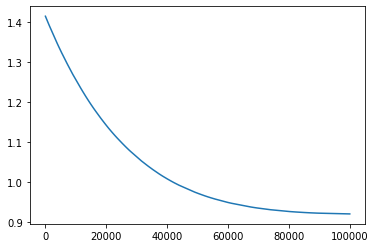

In [8]:
plt.plot(range(len(rel_diffs)), rel_diffs)

You should see it converging, but not especially quickly.

Finally, if the dimension is `n=1`, let's go ahead and do a sanity-check regression fit plot. The plot can change if the notebooks are re-run from start.

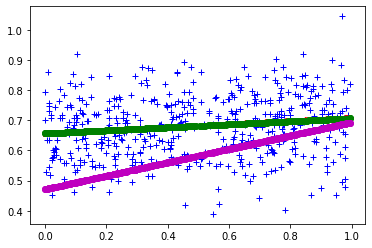

In [9]:
STEP = int(X.shape[0] / 500)
if n == 1:
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(X[::STEP, 1], y[::STEP], 'b+') # blue - data
    ax1.plot(X[::STEP, 1], X.dot(theta_true)[::STEP], 'r*') # red - true
    ax1.plot(X[::STEP, 1], X.dot(theta)[::STEP], 'go') # green - batch
    ax1.plot(X[::STEP, 1], X.dot(theta_lms)[::STEP], 'mo') # magenta - pure LMS
else:
    print("Plot is multidimensional; I live in Flatland, so I don't do that.")

**Exercise 2** (_ungraded_, optional). We said previously that, in practice, you would probably do some sort of _hybrid_ scheme that mixes full batch updates (possibly only initially) and incremental updates. Implement such a scheme and describe what you observe. You might observe a different plot each time the cell is re-run.

In [10]:
# Setup problem and compute the batch solution
m = 100000
n = 1
theta_true = generate_model(n)
(X, y) = generate_data(m, theta_true, sigma=0.1)
theta_batch = estimate_coeffs(X, y)

# Your turn, below: Implement a hybrid batch-LMS solution
# assuming you observe the first few data points all at
# once, and then see the remaining points one at a time.

###
### YOUR CODE HERE
###


**Fin!** If you've gotten this far without errors, your notebook is ready to submit.